Loaded Cora dataset with 2708 nodes, 10556 edges, and 7 classes.

Training target model (GCN)...
Epoch 0, Loss: 1.9457, Train Accuracy: 0.1857
Epoch 50, Loss: 1.8039, Train Accuracy: 0.9500
Epoch 100, Loss: 1.5640, Train Accuracy: 0.9500
Epoch 150, Loss: 1.2836, Train Accuracy: 0.9500
Training Shadow Model (GCN)...
Epoch 0, Loss: 1.9469, Train Accuracy: 0.0786
Epoch 50, Loss: 1.8188, Train Accuracy: 0.9214
Epoch 100, Loss: 1.5832, Train Accuracy: 0.9357
Epoch 150, Loss: 1.2935, Train Accuracy: 0.9643
Running Posterior-Only Attack (GCN)...
Running Combined Attack (GCN)...
Running Edge Perturbation Attack (GCN)...
Running Link Prediction Attack (GCN)...

Training target model (GraphSAGE)...
Epoch 0, Loss: 1.9477, Train Accuracy: 0.1429
Epoch 50, Loss: 1.7043, Train Accuracy: 0.9929
Epoch 100, Loss: 1.1882, Train Accuracy: 0.9857
Epoch 150, Loss: 0.6591, Train Accuracy: 0.9857
Training Shadow Model (GraphSAGE)...
Epoch 0, Loss: 1.9491, Train Accuracy: 0.1357
Epoch 50, Loss: 1.7281, Train 

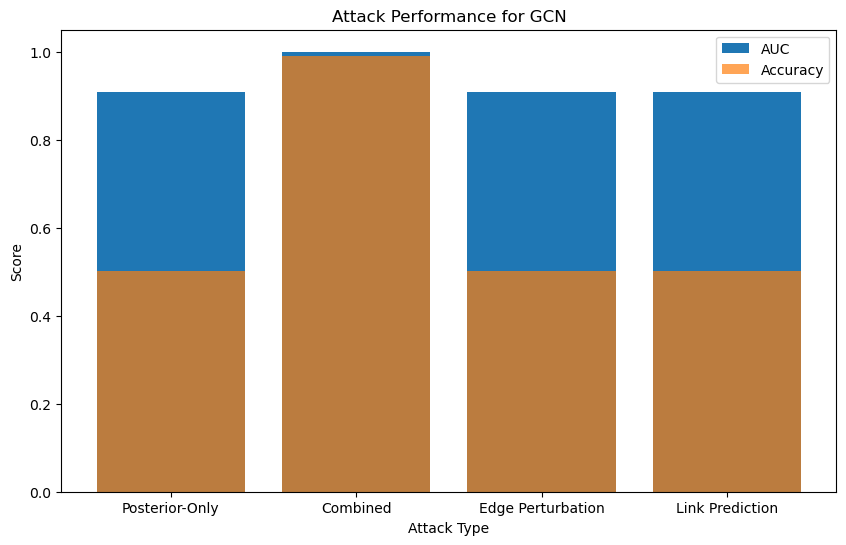

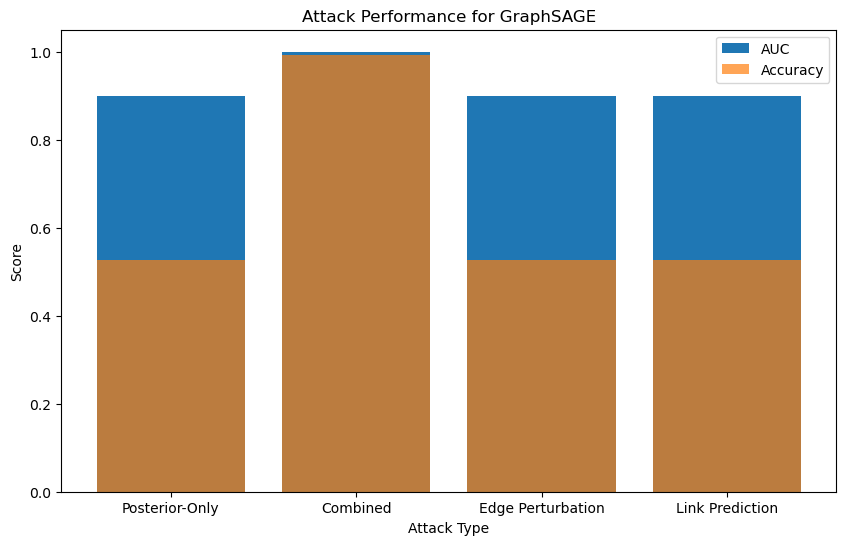

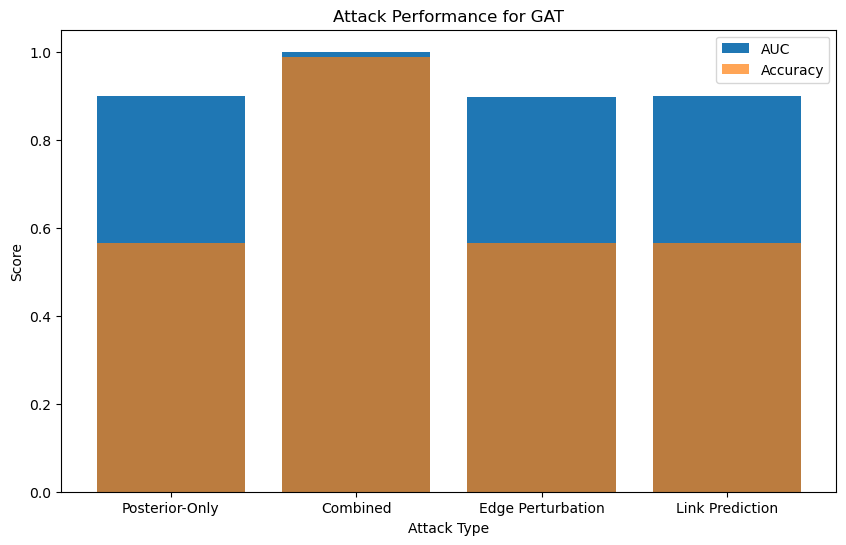

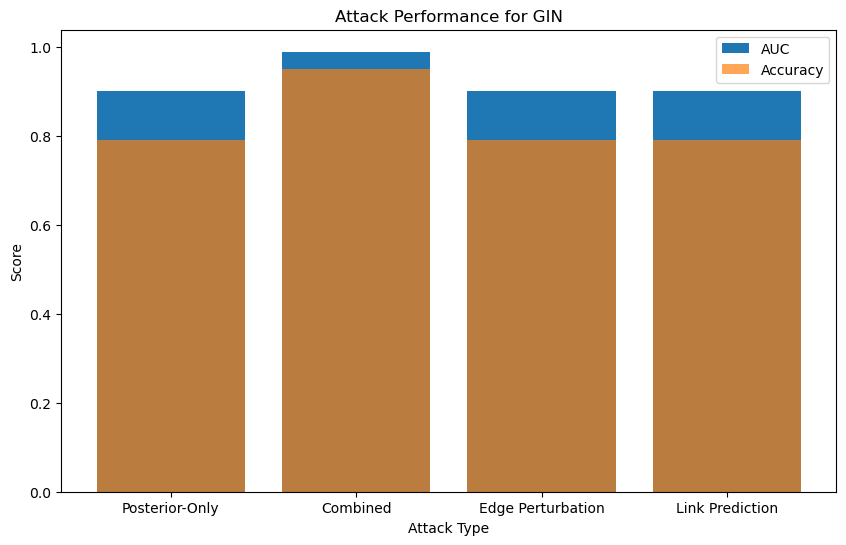

In [1]:
import torch
from torch.nn import Linear, Dropout, ModuleList
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Step 1: Load and Preprocess Dataset
def load_dataset(name):
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=NormalizeFeatures())
    data = dataset[0]
    print(f"Loaded {name} dataset with {data.num_nodes} nodes, {data.num_edges} edges, and {len(data.y.unique())} classes.")
    return dataset, data

# Step 2: Define GNN Model
class GNN(torch.nn.Module):
    def __init__(self, model_type, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.dropout = Dropout(p=dropout)
        if model_type == 'GCN':
            self.layers = ModuleList([
                GCNConv(in_channels, hidden_channels),
                GCNConv(hidden_channels, out_channels)
            ])
        elif model_type == 'GraphSAGE':
            self.layers = ModuleList([
                SAGEConv(in_channels, hidden_channels),
                SAGEConv(hidden_channels, out_channels)
            ])
        elif model_type == 'GAT':
            self.layers = ModuleList([
                GATConv(in_channels, hidden_channels, heads=2),
                GATConv(2 * hidden_channels, out_channels, heads=1)
            ])
        elif model_type == 'GIN':
            self.layers = ModuleList([
                GINConv(Linear(in_channels, hidden_channels)),
                GINConv(Linear(hidden_channels, out_channels))
            ])
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = self.dropout(layer(x, edge_index).relu())
        return self.layers[-1](x, edge_index)

# Step 3: Train the Model
def train_model(model, data, epochs=200, lr=0.001, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            train_acc = accuracy_score(data.y[data.train_mask].cpu(), out[data.train_mask].argmax(dim=1).cpu())
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")

# Step 4: Generate Negative Edges
def generate_negative_edges(data, num_neg_samples=None):
    num_nodes = data.num_nodes
    existing_edges = set(zip(data.edge_index[0].tolist(), data.edge_index[1].tolist()))
    negative_edges = set()

    num_neg_samples = num_neg_samples or data.edge_index.size(1)

    while len(negative_edges) < num_neg_samples:
        u, v = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if (u, v) not in existing_edges and (v, u) not in existing_edges and u != v:
            negative_edges.add((u, v))

    return list(negative_edges)

# Step 5: Compute Graph Features
def common_neighbors(data, u, v):
    neighbors_u = set(data.edge_index[1][data.edge_index[0] == u].tolist())
    neighbors_v = set(data.edge_index[1][data.edge_index[0] == v].tolist())
    return len(neighbors_u & neighbors_v)

def jaccard_coefficient(data, u, v):
    neighbors_u = set(data.edge_index[1][data.edge_index[0] == u].tolist())
    neighbors_v = set(data.edge_index[1][data.edge_index[0] == v].tolist())
    union_size = len(neighbors_u | neighbors_v)
    return len(neighbors_u & neighbors_v) / union_size if union_size > 0 else 0

def preferential_attachment(data, u, v):
    neighbors_u = len(data.edge_index[1][data.edge_index[0] == u].tolist())
    neighbors_v = len(data.edge_index[1][data.edge_index[0] == v].tolist())
    return neighbors_u * neighbors_v

def adamic_adar(data, u, v):
    neighbors_u = set(data.edge_index[1][data.edge_index[0] == u].tolist())
    neighbors_v = set(data.edge_index[1][data.edge_index[0] == v].tolist())
    shared_neighbors = neighbors_u & neighbors_v
    return sum(1 / np.log(len(data.edge_index[1][data.edge_index[0] == w].tolist())) for w in shared_neighbors if len(data.edge_index[1][data.edge_index[0] == w].tolist()) > 1)

def compute_graph_features(data):
    graph_features = {}
    for u, v in zip(data.edge_index[0].tolist(), data.edge_index[1].tolist()):
        graph_features[(u, v)] = 1.0
        graph_features[(u, v)] += common_neighbors(data, u, v)
        graph_features[(u, v)] += jaccard_coefficient(data, u, v)
        graph_features[(u, v)] += preferential_attachment(data, u, v)
        graph_features[(u, v)] += adamic_adar(data, u, v)
    return graph_features

# Step 6: Posterior-Only Attack
class PosteriorOnlyAttack:
    def __init__(self, model):
        self.model = model

    def infer_link(self, node_pair, data):
        self.model.eval()
        with torch.no_grad():
            output = self.model(data.x, data.edge_index)
        u, v = node_pair
        prob_u = torch.softmax(output[u], dim=0)
        prob_v = torch.softmax(output[v], dim=0)
        return torch.dot(prob_u, prob_v).item()

# Step 7: Combined Attack
class CombinedAttack:
    def __init__(self, model):
        self.model = model

    def infer_link(self, node_pair, data, graph_features):
        self.model.eval()
        with torch.no_grad():
            output = self.model(data.x, data.edge_index)
        u, v = node_pair
        prob_u = torch.softmax(output[u], dim=0)
        prob_v = torch.softmax(output[v], dim=0)
        posterior_score = torch.dot(prob_u, prob_v).item()
        feature_score = graph_features.get((u, v), 1.0)
        return posterior_score * feature_score

# Step 8: Shadow Model Implementation
def train_shadow_model(data, dataset, model_type='GraphSAGE', hidden_channels=64, dropout=0.5):
    shadow_model = GNN(model_type, dataset.num_node_features, hidden_channels, dataset.num_classes, dropout)
    print(f"Training Shadow Model ({model_type})...")
    train_model(shadow_model, data)
    return shadow_model

# Step 9: Enhanced Attacks
# Adversarial Edge Perturbation Attack
class EdgePerturbationAttack:
    def __init__(self, model):
        self.model = model

    def perturb_edges(self, data, num_perturbations):
        perturbed_data = data.clone()
        edge_index = data.edge_index.clone()
        for _ in range(num_perturbations):
            u, v = random.randint(0, data.num_nodes - 1), random.randint(0, data.num_nodes - 1)
            edge_index = torch.cat([edge_index, torch.tensor([[u], [v]])], dim=1)
        perturbed_data.edge_index = edge_index
        return perturbed_data

# Link Prediction Attack
class LinkPredictionAttack:
    def __init__(self, model):
        self.model = model

    def predict_links(self, data, edges):
        self.model.eval()
        with torch.no_grad():
            output = self.model(data.x, data.edge_index)
        predictions = []
        for u, v in edges:
            prob_u = torch.softmax(output[u], dim=0)
            prob_v = torch.softmax(output[v], dim=0)
            predictions.append(torch.dot(prob_u, prob_v).item())
        return predictions

# Step 10: Evaluate Attack
def evaluate_attack(predictions, true_labels):
    if len(set(true_labels)) < 2:
        print("Warning: Only one class present in true_labels. AUC is not defined.")
        return None, None, None, None, None

    auc = roc_auc_score(true_labels, predictions)
    acc = accuracy_score(true_labels, [1 if p > 0.5 else 0 for p in predictions])
    precision = precision_score(true_labels, [1 if p > 0.5 else 0 for p in predictions], zero_division=0)
    recall = recall_score(true_labels, [1 if p > 0.5 else 0 for p in predictions], zero_division=0)
    f1 = f1_score(true_labels, [1 if p > 0.5 else 0 for p in predictions], zero_division=0)
    return auc, acc, precision, recall, f1

# Step 11: Main Pipeline with Configurable Hyperparameters
def main_pipeline(dataset_name="Cora", model_types=['GCN', 'GraphSAGE', 'GAT', 'GIN'], hidden_channels=64, dropout=0.5, lr=0.001, epochs=200):
    results = []

    # Load dataset
    dataset, data = load_dataset(dataset_name)

    for model_type in model_types:
        # Train target model
        print(f"\nTraining target model ({model_type})...")
        target_model = GNN(model_type, dataset.num_node_features, hidden_channels, dataset.num_classes, dropout)
        train_model(target_model, data, epochs, lr)

        # Train shadow model
        shadow_model = train_shadow_model(data, dataset, model_type, hidden_channels, dropout)

        # Generate pairs for attacks
        negative_edges = generate_negative_edges(data)
        positive_edges = list(zip(data.edge_index[0].tolist(), data.edge_index[1].tolist()))
        all_edges = positive_edges + negative_edges
        true_labels = [1] * len(positive_edges) + [0] * len(negative_edges)

        # Posterior-Only Attack
        print(f"Running Posterior-Only Attack ({model_type})...")
        attack = PosteriorOnlyAttack(target_model)
        predictions = [attack.infer_link((u, v), data) for u, v in all_edges]
        auc, acc, precision, recall, f1 = evaluate_attack(predictions, true_labels)
        results.append({"Model": model_type, "Attack": "Posterior-Only", "AUC": auc, "Accuracy": acc, "Precision": precision, "Recall": recall, "F1": f1})

        # Combined Attack
        print(f"Running Combined Attack ({model_type})...")
        graph_features = compute_graph_features(data)
        combined_attack = CombinedAttack(target_model)
        combined_predictions = [combined_attack.infer_link((u, v), data, graph_features) for u, v in all_edges]
        auc_combined, acc_combined, precision_combined, recall_combined, f1_combined = evaluate_attack(combined_predictions, true_labels)
        results.append({"Model": model_type, "Attack": "Combined", "AUC": auc_combined, "Accuracy": acc_combined, "Precision": precision_combined, "Recall": recall_combined, "F1": f1_combined})

        # Edge Perturbation Attack
        print(f"Running Edge Perturbation Attack ({model_type})...")
        edge_attack = EdgePerturbationAttack(target_model)
        perturbed_data = edge_attack.perturb_edges(data, num_perturbations=10)
        edge_predictions = [attack.infer_link((u, v), perturbed_data) for u, v in all_edges]
        auc_edge, acc_edge, precision_edge, recall_edge, f1_edge = evaluate_attack(edge_predictions, true_labels)
        results.append({"Model": model_type, "Attack": "Edge Perturbation", "AUC": auc_edge, "Accuracy": acc_edge, "Precision": precision_edge, "Recall": recall_edge, "F1": f1_edge})

        # Link Prediction Attack
        print(f"Running Link Prediction Attack ({model_type})...")
        link_attack = LinkPredictionAttack(target_model)
        link_predictions = link_attack.predict_links(data, all_edges)
        auc_link, acc_link, precision_link, recall_link, f1_link = evaluate_attack(link_predictions, true_labels)
        results.append({"Model": model_type, "Attack": "Link Prediction", "AUC": auc_link, "Accuracy": acc_link, "Precision": precision_link, "Recall": recall_link, "F1": f1_link})

    results_df = pd.DataFrame(results)
    print("\nFinal Results:")
    print(results_df)
    return results_df

# Step 12: Plot Results
def plot_results(results_df):
    for model in results_df["Model"].unique():
        subset = results_df[results_df["Model"] == model]
        plt.figure(figsize=(10, 6))
        plt.bar(subset["Attack"], subset["AUC"], label="AUC")
        plt.bar(subset["Attack"], subset["Accuracy"], label="Accuracy", alpha=0.7)
        plt.title(f"Attack Performance for {model}")
        plt.xlabel("Attack Type")
        plt.ylabel("Score")
        plt.legend()
        plt.show()

results_df = main_pipeline()
plot_results(results_df)
